# Problem 2-3 & 2-4

## Basic Setup

In [1]:
rm(list=ls()) # clear workspace library(igraph)

# call igraph
library('igraph')
library('Matrix')
library('pracma')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘pracma’

The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu



## Random walk function

In [2]:
create_transition_matrix = function (g){
  
  # WARNING: make sure your graph is connected (you might input GCC of your graph)
  
  vs = V(g)
  n = vcount(g)
  adj = as_adjacency_matrix(g)
  adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
  z = matrix(rowSums(adj, , 1))
  
  transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
  
  return(transition_matrix)
}

In [3]:
# create a random walk
random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
  if(is.null(transition_matrix))
    transition_matrix = create_transition_matrix(g)
  
  v <- start_node
  for(i in 1:num_steps){
    #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
    PMF <- transition_matrix[v, ];
    v <- sample(1:vcount(g), 1, prob = PMF);
  }
  
  return(v)
}

### Generate PA Model

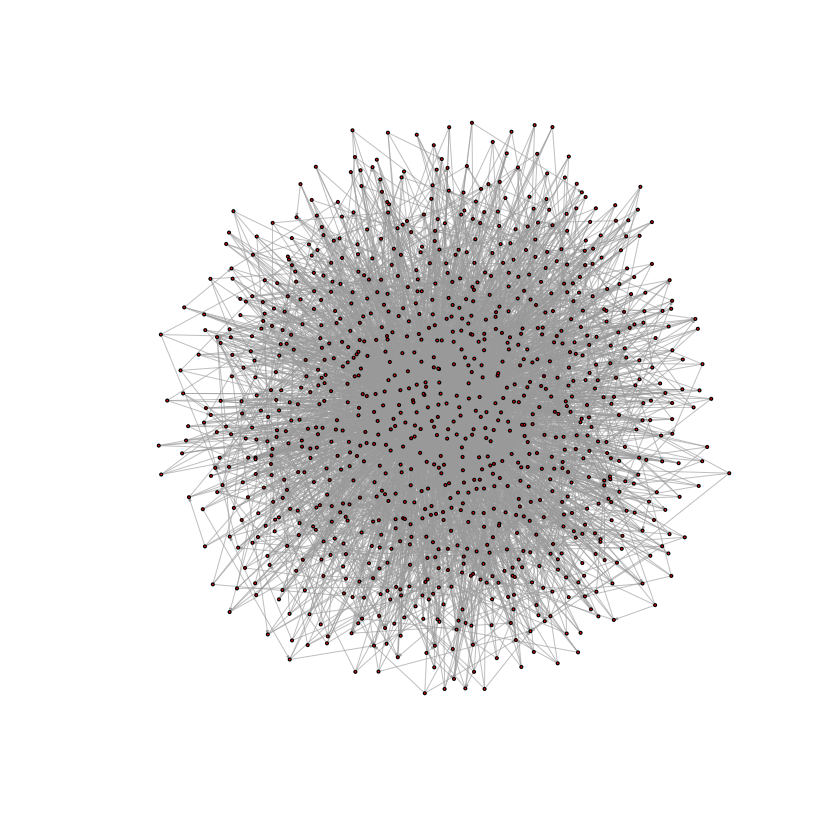

In [4]:
# gengerate network with PA model
set.seed(0)
g = barabasi.game(1000, m=4, directed = TRUE)
plot(g,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1)
#print(create_transition_matrix(g))

In [5]:
# calculate degree
cal_degree = function(g, option="all"){
  num_vertex <- length(V(g));
  degree_list <- c();
  for (i in seq(1, num_vertex)){
    degree_list[i] <- degree(graph=g,v=i,mode=option);
  }
  
  degree_df <- data.frame("vertex"=seq(1,num_vertex), "degree"=degree_list);
  return(degree_df);
}

# calculate page rank
calc_pgrank = function(graph, num_step, num_exp){
  sum_node <- c();
  start_node <- as.integer(runif(num_exp,min=1,max=length(V(graph))+1));
  # do num_step experimemnts
  for (i in seq(1,num_exp)){
    v_last <- random_walk(graph, start_node=start_node[i], num_steps=num_step);
    sum_node <- append(sum_node,v_last);
    #print(i)
  }
  
  prob_vertex <- table(sum_node) / length(sum_node);
  prob_vertex_df <- as.data.frame(prob_vertex);
  names(prob_vertex_df) <- c("vertex","probablity");
  
  return(prob_vertex_df)
}

In [6]:
prob_vertex_df <- calc_pgrank(graph=g, num_step=100, num_exp=1000);
degree_df <- cal_degree(g);
sum_df <- merge(degree_df, prob_vertex_df, by="vertex");

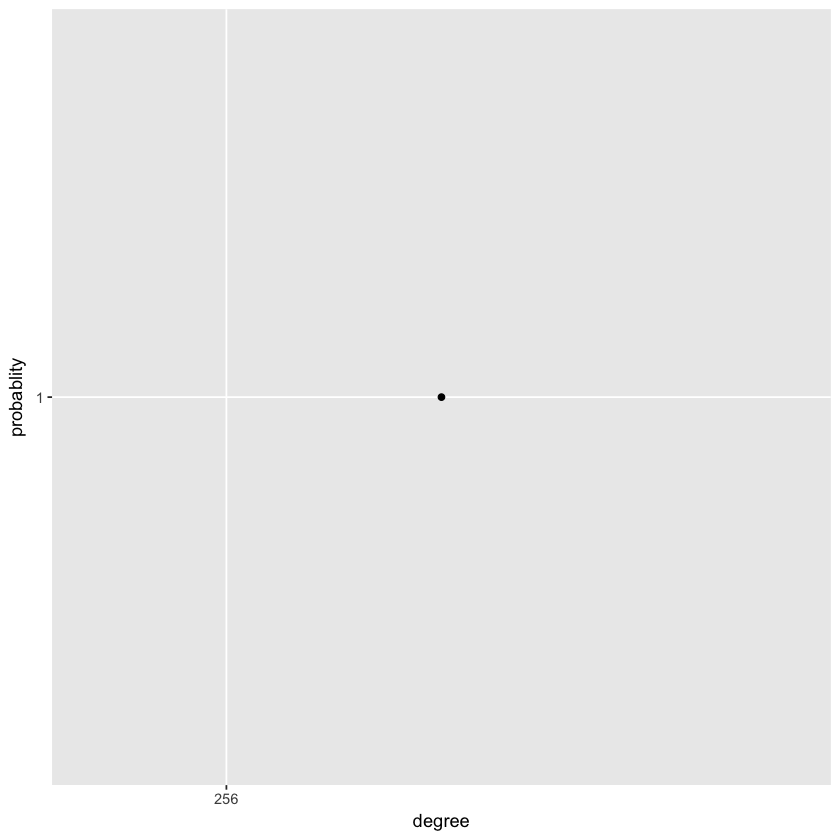

In [7]:
library("ggplot2")
p <- ggplot(sum_df, aes(x=degree,y=probablity), alpha=0.5) + geom_point()
p <- p + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2');
p <- p + geom_smooth(method=lm);
p

## Solution to Problem 3-2

In [8]:
teleport = function (g, num_steps, start_node, alpha = 0.15){
  # a simple implementation of teleportation
  transition_matrix <- create_transition_matrix(g);
  num_vertex <- length(V(g)); # number of vertex
  
  v <- start_node;
  for(i in 1:num_steps){
    deg <- degree(g, v, mode="out");
    if (deg == 0){
      # if it is in dead end
      v <- as.integer(runif(1, min=1, max=num_vertex+1));
    }
    else{
      # or not dead
      rand_incident <- runif(1, min = 0, max = 1);
      if (rand_incident >= alpha){
        PMF <- transition_matrix[v, ];
        v <- sample(1:vcount(g), 1, prob = PMF);
      }
      else{
        # w/ prob.=alpha, jump to random page
        v <- as.integer(runif(1, min=1, max=num_vertex+1));
    }
  }
  }
  
  return(v)
}

calc_tele = function(graph, num_step, num_exp, alpha){
  sum_path2 <- c();
  start_node <- as.integer(runif(num_exp,min=1,max=length(V(graph))+1));
  # do 10000 experimemnts
  for (i in seq(1,num_exp)){
    path <- teleport(graph, start_node=start_node[i], num_steps=num_step, alpha=alpha);
    sum_path2 <- append(sum_path2,path);
    #print(i)
  }
  
  prob_vertex2 <- table(sum_path2) / length(sum_path2);
  prob_vertex_df2 <- as.data.frame(prob_vertex2);
  names(prob_vertex_df2) <- c("vertex","probablity");
  
  return(prob_vertex_df2)
}

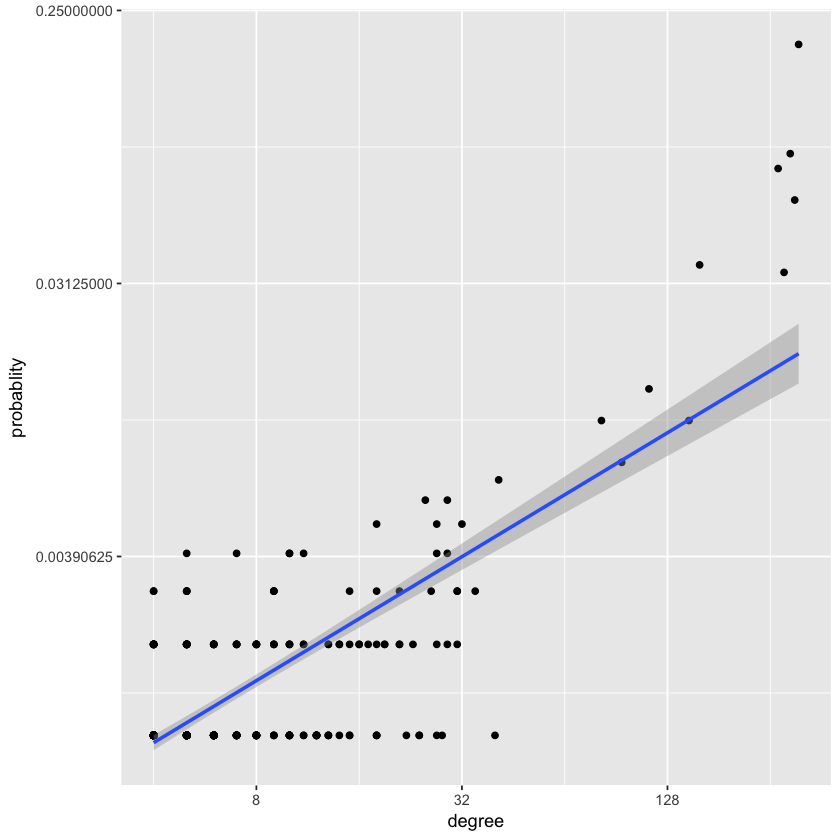

In [13]:
prob_vertex_df2 <- calc_tele(graph=g, num_step=1000, num_exp=1000, alpha=0.15);
degree_df2 <- cal_degree(g);
sum_df2 <- merge(degree_df2, prob_vertex_df2, by="vertex");

library("ggplot2")
p <- ggplot(sum_df2, aes(x=degree,y=probablity), alpha=0.5) + geom_point()
p <- p + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2');
p <- p + geom_smooth(method=lm);
p

In [14]:
cor.test(sum_df2$degree,sum_df2$probablity)


	Pearson's product-moment correlation

data:  sum_df2$degree and sum_df2$probablity
t = 28.183, df = 344, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8003996 0.8646241
sample estimates:
      cor 
0.8353401 


## Solution to Problem 4-1

In [260]:
norm_rank_df <- calc_tele(graph=g, num_step=1000, num_exp=10000, alpha=1/length(V(g)));

In [261]:
prob_set <- rep(1/1000,1000);
for (i in seq(1, length(norm_rank_df$vertex))){
    ind <- norm_rank_df[i,]$vertex;
    pb <- norm_rank_df[i,]$probablity;
    prob_set[ind] <- pb;
}

In [262]:
personized_pr = function (graph, num_steps, start_node, prob_set, alpha=0.15){
  # a simple implementation of teleportation
  transition_matrix <- create_transition_matrix(g);
  num_vertex <- length(V(graph)); # number of vertex
  
  v <- start_node;
  for(i in 1:num_steps){
    deg <- degree(graph, v, mode="out");
    if (deg == 0){
      # if it is in dead end
      v <- as.integer(runif(1, min=1, max=num_vertex+1));
    }
    else{
      # or not dead
      rand_incident <- runif(1, min = 0, max = 1);
      # calculate alpha of vertex
      if (rand_incident >= alpha){
        PMF <- transition_matrix[v, ];
        PMFPP <- PMF * prob_set * (1 / sum(PMF * prob_set));
        v <- sample(1:vcount(graph), 1, prob = PMFPP);
      }
      else{
        # w/ prob.=alpha, jump to random page
        v <- as.integer(runif(1, min=1, max=num_vertex+1));
      }
    }
  }
  
  return(v)
}

In [263]:
calc_tele_personized = function(graph, num_step, num_exp, prob_set, alpha=0.15){
  sum_path <- c();
  start_node <- as.integer(runif(num_exp,min=1,max=length(V(graph))+1));
  # do 10000 experimemnts
  for (i in seq(1,num_exp)){
    path <- personized_pr(graph, start_node=start_node[i], num_steps=num_step, prob_set=prob_set, alpha=alpha);
    sum_path <- append(sum_path,path);
    #print(i)
  }
  
  prob_vertex <- table(sum_path) / length(sum_path);
  prob_vertex_df <- as.data.frame(prob_vertex);
  names(prob_vertex_df) <- c("vertex","probablity");
  
  return(prob_vertex_df)
}

In [264]:
personized_rk_df <- calc_tele_personized(g, num_step=1000, num_exp=10000, prob_set=prob_set,alpha=0.15);
new_df <- merge(norm_rank_df, personized_rk_df, by="vertex");

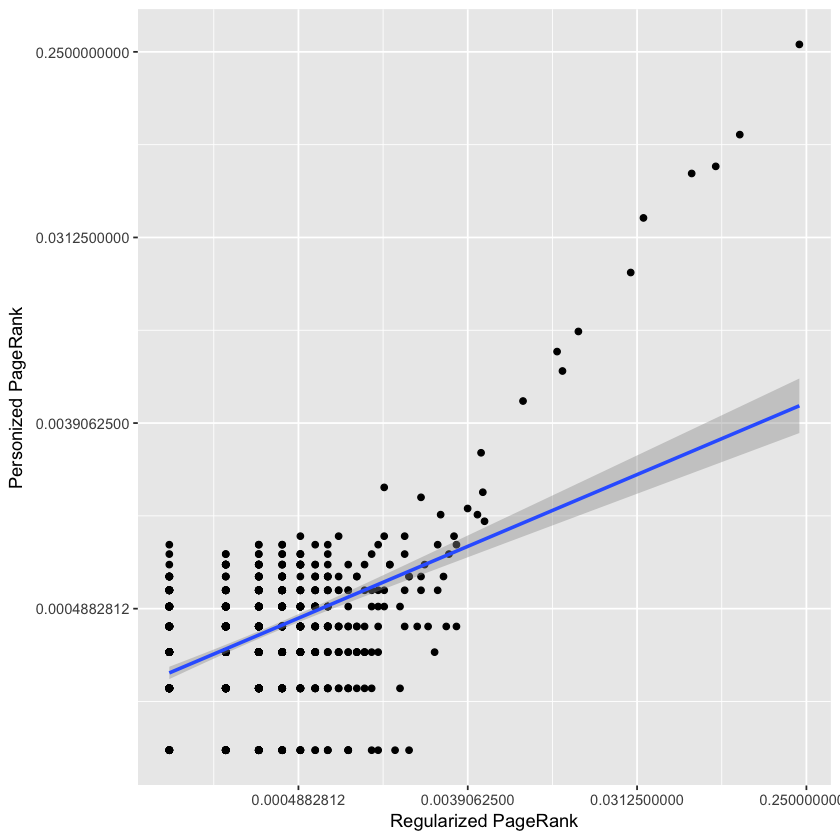

In [265]:
# plot
p <- ggplot(new_df, aes(x=probablity.x,y=probablity.y), alpha=0.5) + geom_point()
p <- p + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2');
p <- p + geom_smooth(method=lm);
p <- p + labs(x="Regularized PageRank", y="Personized PageRank")
p

In [266]:
diff_pr = function(df1, df2){
  df_merged <- merge(df1, df2, by="vertex");
  diff <- df_merged$probablity.x - df_merged$probablity.y;
  df_merged <- data.frame(df_merged, "diff" = diff);
  names(df_merged) <- c("vertex","df_1","df_2","prob_diff");
  return(df_merged);
}

In [267]:
diff_pr_norm_per <- diff_pr(norm_rank_df, personized_rk_df);

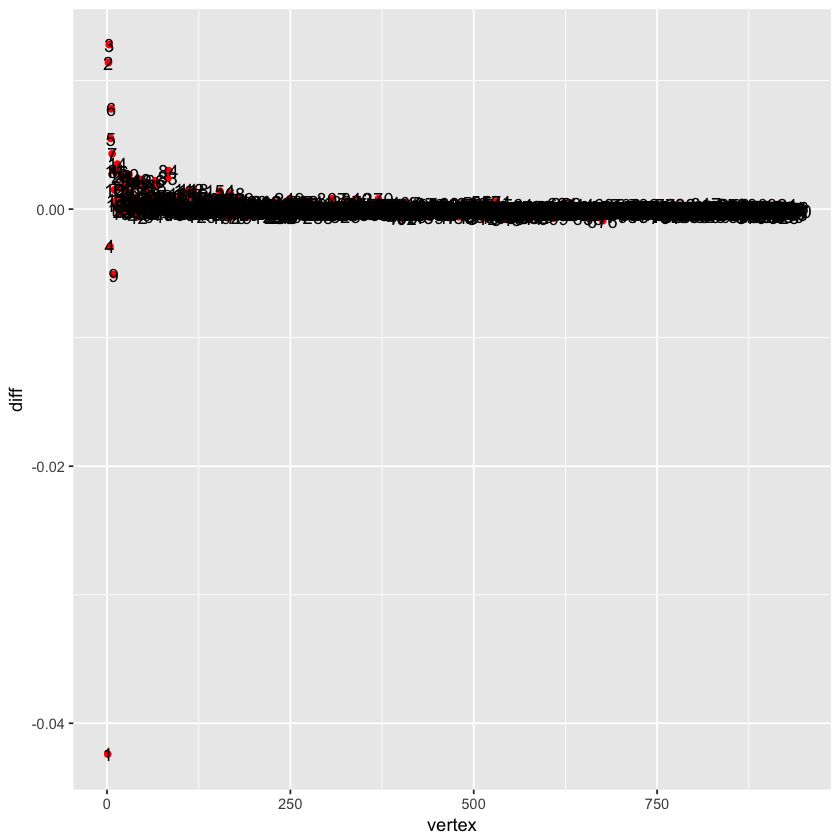

In [268]:
diff_pr_norm_per$vertex <- as.numeric(diff_pr_norm_per$vertex)
p <- ggplot(diff_pr_norm_per, aes(x=vertex,y=prob_diff)) + geom_point(color='red')
p <- p + labs(x="vertex", y="diff")
p <- p + geom_text(aes(x=vertex,y=prob_diff), label=diff_pr_norm_per$vertex)
p

In [269]:
diff_pr_norm_per <- merge(diff_pr_norm_per, degree_df, by="vertex")
diff_pr_norm_per$prob_diff <- abs(diff_pr_norm_per$prob_diff)

In [270]:
cor.test(diff_pr_norm_per$degree,diff_pr_norm_per$prob_diff)


	Pearson's product-moment correlation

data:  diff_pr_norm_per$degree and diff_pr_norm_per$prob_diff
t = 32.735, df = 918, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7025790 0.7623586
sample estimates:
      cor 
0.7338866 


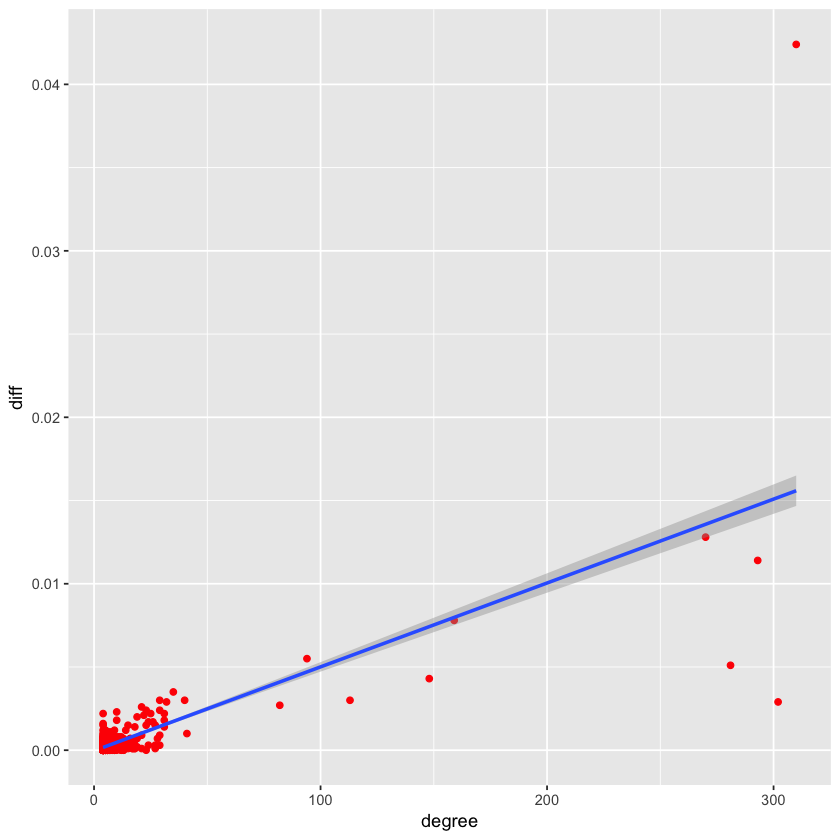

In [271]:
p <- ggplot(diff_pr_norm_per, aes(x=degree,y=prob_diff)) + geom_point(color='red');
p <- p + labs(x="degree", y="diff");
#p <- p + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2');
p <- p + geom_smooth(method=lm);
p

## Solution to Problem 4-2

In [281]:
v1 <- order(diff_pr_norm_per$df_2)[length(diff_pr_norm_per$df_2)/2];
v2 <- order(diff_pr_norm_per$df_2)[length(diff_pr_norm_per$df_2)/2+1];
v_list <- c(v1, v2);
v_list


[1] 364 370

In [300]:
personized_pr_mod = function (graph, num_steps, start_node, alpha=0.15, prob_set, v_list){
  # a simple implementation of teleportation
  transition_matrix <- create_transition_matrix(g);
  num_vertex <- length(V(graph)); # number of vertex
  
  v <- start_node;
  for(i in 1:num_steps){
    PMF  <- transition_matrix[v, ];
    PMFPP <- PMF * prob_set * (1 / sum(PMF * prob_set));
    if (v == 1){
        ss <- runif(1, min = 0, max = 1);
        if (ss < 0.5){
            v <- v_list[1];
        }
        else {
         v <- v_list[2];   
        }
    }
    else{
     v  <- sample(1:vcount(g), 1, prob = PMF);   
    }
    # teleportation
    pg <- runif(1, 0, 1);
    if (pg < alpha) {
                ss <- runif(1, min = 0, max = 1);
        if (ss < 0.5){
            v <- v_list[1];
        }
        else {
         v <- v_list[2];   
        }
    }
    }
  
  return(v)
}

In [301]:
calc_tele_personized_mod = function(graph, num_step, num_exp, alpha, prob_set, v_list){
  sum_path <- c();
  start_node <- as.integer(runif(num_exp,min=1,max=length(V(graph))+1));
  # do 10000 experimemnts
  for (i in seq(1,num_exp)){
    path <- personized_pr_mod(graph, start_node=start_node[i], num_steps=num_step, prob_set=prob_set,
                              alpha=alpha, v_list=v_list);
    sum_path <- append(sum_path,path);
    #print(i)
  }
  
  prob_vertex <- table(sum_path) / length(sum_path);
  prob_vertex_df <- as.data.frame(prob_vertex);
  names(prob_vertex_df) <- c("vertex","probablity");
  
  return(prob_vertex_df)
}

In [302]:
pg_rank <- page_rank(g, directed = TRUE, damping = 0.85)

In [317]:
new_pr <- calc_tele_personized_mod(g, num_step=1000, num_exp=1000, alpha=0.15, v_list=v_list, prob_set=pg_rank$vector);

In [318]:
diff_newpr_newdf <- merge(new_pr, personized_rk_df, by="vertex");
diff <- diff_newpr_newdf$probablity.x - diff_newpr_newdf$probablity.y;
diff_newpr_newdf <- data.frame(diff_newpr_newdf, "diff" = diff);
names(diff_newpr_newdf) <- c("vertex","df_1","df_2","prob_diff");

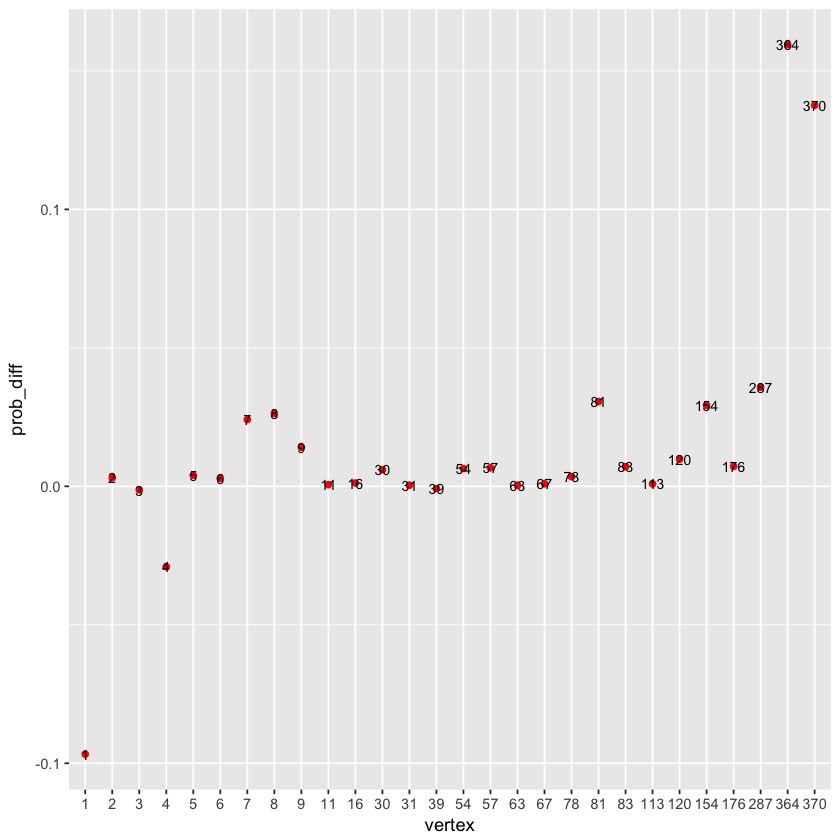

In [319]:
p <- ggplot(diff_newpr_newdf, aes(x=vertex,y=prob_diff)) + geom_point(color="red")
p <- p + geom_text(aes(x=vertex,y=prob_diff), label=diff_newpr_newdf$vertex, size=3)
p